**Data Preprocessing**

In [38]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/MarketPricePrediction (1).csv')

# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')

# Handling missing values: filling missing values with the median of the respective column
data.fillna(data.median(numeric_only=True), inplace=True)

# Encoding categorical variables using one-hot encoding
data = pd.get_dummies(data, columns=['market', 'state', 'city'], drop_first=True)

# Display the first few rows after preprocessing
print(data.head())


     month  year  quantity  priceMin  priceMax  priceMod       date  \
0  January  2005      2350       404       493       446 2005-01-01   
1  January  2006       900       487       638       563 2006-01-01   
2  January  2010       790      1283      1592      1460 2010-01-01   
3  January  2011       245      3067      3750      3433 2011-01-01   
4  January  2012      1035       523       686       605 2012-01-01   

   market_AGRA(UP)  market_AHMEDABAD(GUJ)  market_AHMEDNAGAR(MS)  ...  \
0            False                  False                  False  ...   
1            False                  False                  False  ...   
2            False                  False                  False  ...   
3            False                  False                  False  ...   
4            False                  False                  False  ...   

   city_SRIGANGANAGAR  city_SRINAGAR  city_SRIRAMPUR  city_SURAT  \
0               False          False           False       False  

**Visualizing Time Series Data and Seasonality/Trends Analysis**

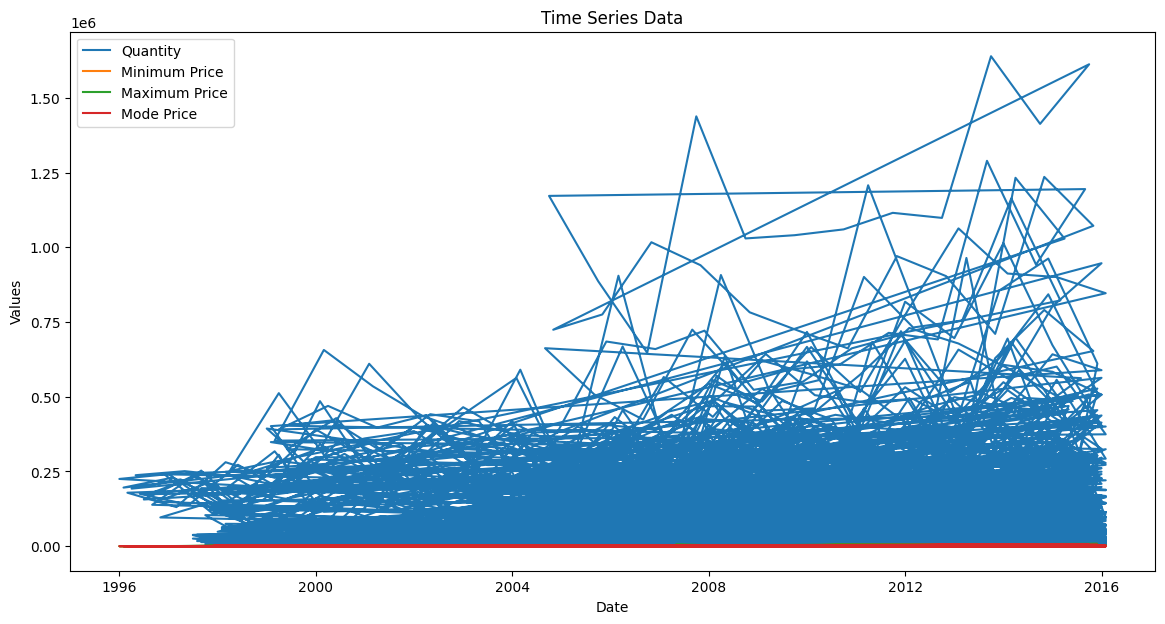

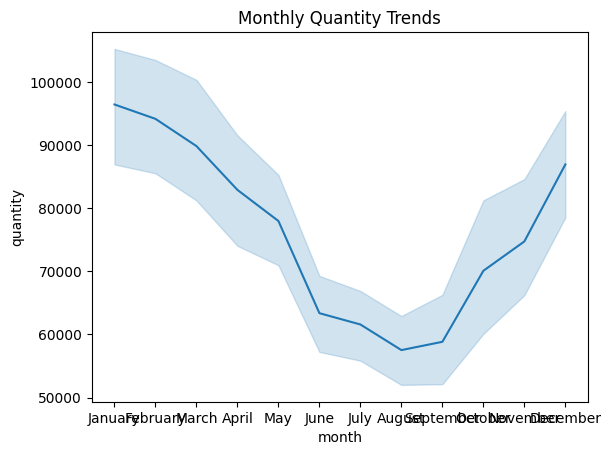

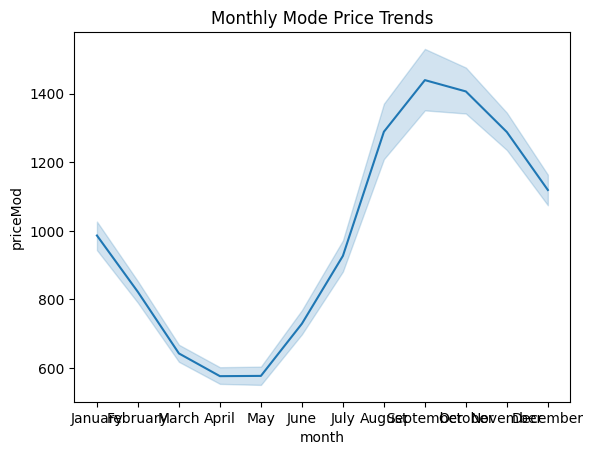

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the time series data
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['quantity'], label='Quantity')
plt.plot(data['date'], data['priceMin'], label='Minimum Price')
plt.plot(data['date'], data['priceMax'], label='Maximum Price')
plt.plot(data['date'], data['priceMod'], label='Mode Price')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.show()

# Checking for seasonality and trends
sns.lineplot(x='month', y='quantity', data=data, estimator='mean')
plt.title('Monthly Quantity Trends')
plt.show()

sns.lineplot(x='month', y='priceMod', data=data, estimator='mean')
plt.title('Monthly Mode Price Trends')
plt.show()


**Feature Engineering**

In [40]:
# Creating lag features
data['quantity_lag1'] = data['quantity'].shift(1)
data['priceMod_lag1'] = data['priceMod'].shift(1)

# Creating rolling statistics
data['quantity_rolling_mean'] = data['quantity'].rolling(window=3).mean()
data['priceMod_rolling_mean'] = data['priceMod'].rolling(window=3).mean()

# Dropping rows with NaN values generated by lag and rolling features
data.dropna(inplace=True)

# Display the first few rows after feature engineering
print(data.head())


     month  year  quantity  priceMin  priceMax  priceMod       date  \
2  January  2010       790      1283      1592      1460 2010-01-01   
3  January  2011       245      3067      3750      3433 2011-01-01   
4  January  2012      1035       523       686       605 2012-01-01   
5  January  2013       675      1327      1900      1605 2013-01-01   
6  January  2014       440      1025      1481      1256 2014-01-01   

   market_AGRA(UP)  market_AHMEDABAD(GUJ)  market_AHMEDNAGAR(MS)  ...  \
2            False                  False                  False  ...   
3            False                  False                  False  ...   
4            False                  False                  False  ...   
5            False                  False                  False  ...   
6            False                  False                  False  ...   

   city_TRIVENDRUM  city_UDAIPUR  city_UJJAIN  city_VANI  city_VARANASI  \
2            False         False        False      False   

**ARIMA Modeling and Evaluation**

In [41]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define ARIMA order
order = (5, 1, 0)

# Fit ARIMA models and make predictions
def fit_arima_and_forecast(data, column):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored")
        model = ARIMA(data[column], order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=12)
    return forecast

quantity_pred_arima = fit_arima_and_forecast(data, 'quantity')
priceMod_pred_arima = fit_arima_and_forecast(data, 'priceMod')

# Evaluation
print(f'ARIMA MAE (Quantity): {mean_absolute_error(data["quantity"][-12:], quantity_pred_arima)}')
print(f'ARIMA MSE (Quantity): {mean_squared_error(data["quantity"][-12:], quantity_pred_arima)}')
print(f'ARIMA RMSE (Quantity): {np.sqrt(mean_squared_error(data["quantity"][-12:], quantity_pred_arima))}')

print(f'ARIMA MAE (Price Mode): {mean_absolute_error(data["priceMod"][-12:], priceMod_pred_arima)}')
print(f'ARIMA MSE (Price Mode): {mean_squared_error(data["priceMod"][-12:], priceMod_pred_arima)}')
print(f'ARIMA RMSE (Price Mode): {np.sqrt(mean_squared_error(data["priceMod"][-12:], priceMod_pred_arima))}')




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA MAE (Quantity): 60765.461985182046
ARIMA MSE (Quantity): 5618378858.372587
ARIMA RMSE (Quantity): 74955.84605868036
ARIMA MAE (Price Mode): 425.75809225795433
ARIMA MSE (Price Mode): 281078.2815005273
ARIMA RMSE (Price Mode): 530.1681634165968


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


**SARIMA Modeling and Evaluation**

In [42]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# SARIMA model for quantity
sarima_model_quantity = SARIMAX(data['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_quantity_fit = sarima_model_quantity.fit(disp=False)
quantity_pred_sarima = sarima_model_quantity_fit.forecast(steps=12)

# SARIMA model for priceMod
sarima_model_priceMod = SARIMAX(data['priceMod'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_priceMod_fit = sarima_model_priceMod.fit(disp=False)
priceMod_pred_sarima = sarima_model_priceMod_fit.forecast(steps=12)

# Evaluation
print(f'SARIMA MAE (Quantity): {mean_absolute_error(data["quantity"][-12:], quantity_pred_sarima)}')
print(f'SARIMA MSE (Quantity): {mean_squared_error(data["quantity"][-12:], quantity_pred_sarima)}')
print(f'SARIMA RMSE (Quantity): {np.sqrt(mean_squared_error(data["quantity"][-12:], quantity_pred_sarima))}')

print(f'SARIMA MAE (Price Mode): {mean_absolute_error(data["priceMod"][-12:], priceMod_pred_sarima)}')
print(f'SARIMA MSE (Price Mode): {mean_squared_error(data["priceMod"][-12:], priceMod_pred_sarima)}')
print(f'SARIMA RMSE (Price Mode): {np.sqrt(mean_squared_error(data["priceMod"][-12:], priceMod_pred_sarima))}')



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

SARIMA MAE (Quantity): 53147.74090467557
SARIMA MSE (Quantity): 4341585607.1767025
SARIMA RMSE (Quantity): 65890.70956649884
SARIMA MAE (Price Mode): 333.11168688902234
SARIMA MSE (Price Mode): 165541.28068198034
SARIMA RMSE (Price Mode): 406.86764516483777


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


**Prophet Modeling and Evaluation**

In [43]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Prophet model for quantity
df_quantity = data[['date', 'quantity']].rename(columns={'date': 'ds', 'quantity': 'y'})
prophet_model_quantity = Prophet()
prophet_model_quantity.fit(df_quantity)
future_quantity = prophet_model_quantity.make_future_dataframe(periods=12, freq='M')
quantity_forecast_prophet = prophet_model_quantity.predict(future_quantity)

# Prophet model for priceMod
df_priceMod = data[['date', 'priceMod']].rename(columns={'date': 'ds', 'priceMod': 'y'})
prophet_model_priceMod = Prophet()
prophet_model_priceMod.fit(df_priceMod)
future_priceMod = prophet_model_priceMod.make_future_dataframe(periods=12, freq='M')
priceMod_forecast_prophet = prophet_model_priceMod.predict(future_priceMod)

# Evaluation
print(f'Prophet MAE (Quantity): {mean_absolute_error(data["quantity"][-12:], quantity_forecast_prophet["yhat"][-12:])}')
print(f'Prophet MSE (Quantity): {mean_squared_error(data["quantity"][-12:], quantity_forecast_prophet["yhat"][-12:])}')
print(f'Prophet RMSE (Quantity): {np.sqrt(mean_squared_error(data["quantity"][-12:], quantity_forecast_prophet["yhat"][-12:]))}')

print(f'Prophet MAE (Price Mode): {mean_absolute_error(data["priceMod"][-12:], priceMod_forecast_prophet["yhat"][-12:])}')
print(f'Prophet MSE (Price Mode): {mean_squared_error(data["priceMod"][-12:], priceMod_forecast_prophet["yhat"][-12:])}')
print(f'Prophet RMSE (Price Mode): {np.sqrt(mean_squared_error(data["priceMod"][-12:], priceMod_forecast_prophet["yhat"][-12:]))}')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp557ohu5t/8nddmlsv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp557ohu5t/mxcohqq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71593', 'data', 'file=/tmp/tmp557ohu5t/8nddmlsv.json', 'init=/tmp/tmp557ohu5t/mxcohqq8.json', 'output', 'file=/tmp/tmp557ohu5t/prophet_model00iwe415/prophet_model-20240527135905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:59:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Prophet MAE (Quantity): 79070.5095075381
Prophet MSE (Quantity): 9143683631.934614
Prophet RMSE (Quantity): 95622.61046392017
Prophet MAE (Price Mode): 902.4875271056263
Prophet MSE (Price Mode): 951627.8982092956
Prophet RMSE (Price Mode): 975.5141711986021


**LSTM Modeling and Evaluation**

Epoch 1/50
205/205 [==============================] - 3s 4ms/step - loss: 11633444864.0000 - val_loss: 14298734592.0000
Epoch 2/50
205/205 [==============================] - 1s 3ms/step - loss: 11632783360.0000 - val_loss: 14297152512.0000
Epoch 3/50
205/205 [==============================] - 1s 3ms/step - loss: 11631013888.0000 - val_loss: 14293965824.0000
Epoch 4/50
205/205 [==============================] - 1s 4ms/step - loss: 11628113920.0000 - val_loss: 14289301504.0000
Epoch 5/50
205/205 [==============================] - 1s 3ms/step - loss: 11624296448.0000 - val_loss: 14283492352.0000
Epoch 6/50
205/205 [==============================] - 1s 3ms/step - loss: 11619791872.0000 - val_loss: 14276831232.0000
Epoch 7/50
205/205 [==============================] - 1s 3ms/step - loss: 11614686208.0000 - val_loss: 14269403136.0000
Epoch 8/50
205/205 [==============================] - 1s 3ms/step - loss: 11609029632.0000 - val_loss: 14261173248.0000
Epoch 9/50
205/205 [====================

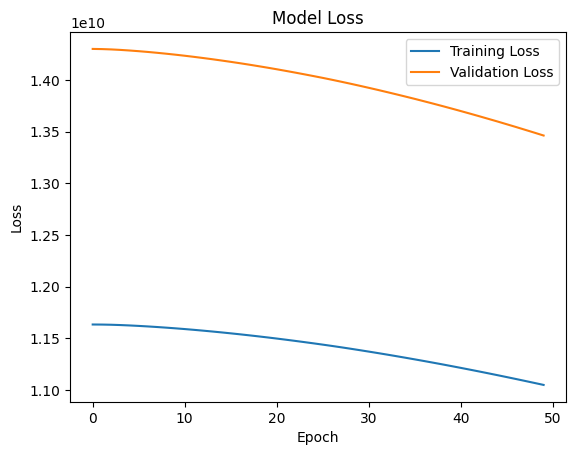

64/64 [==============================] - 0s 2ms/step
LSTM MAE (Quantity): 41354.73612230669
LSTM MSE (Quantity): 8753007996.675625
LSTM RMSE (Quantity): 93557.51170630622
LSTM MAE (Price Mode): 496.97238468086226
LSTM MSE (Price Mode): 464559.1573733766
LSTM RMSE (Price Mode): 681.5857667039245


In [44]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Splitting the data into features and target variables
X = data.drop(columns=['date', 'quantity', 'priceMin', 'priceMax', 'priceMod'])
y = data[['quantity', 'priceMod']]

# Exclude non-numeric columns from X
numeric_columns = X.select_dtypes(include=np.number).columns
X = X[numeric_columns]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Scaling the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping the data for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Making predictions
y_pred = model.predict(X_test_scaled)

# Calculating evaluation metrics
mae_quantity = mean_absolute_error(y_test['quantity'], y_pred[:, 0])
mse_quantity = mean_squared_error(y_test['quantity'], y_pred[:, 0])
rmse_quantity = np.sqrt(mse_quantity)

mae_priceMod = mean_absolute_error(y_test['priceMod'], y_pred[:, 1])
mse_priceMod = mean_squared_error(y_test['priceMod'], y_pred[:, 1])
rmse_priceMod = np.sqrt(mse_priceMod)

print(f'LSTM MAE (Quantity): {mae_quantity}')
print(f'LSTM MSE (Quantity): {mse_quantity}')
print(f'LSTM RMSE (Quantity): {rmse_quantity}')

print(f'LSTM MAE (Price Mode): {mae_priceMod}')
print(f'LSTM MSE (Price Mode): {mse_priceMod}')
print(f'LSTM RMSE (Price Mode): {rmse_priceMod}')


**Fine-tuning LSTM Model with Hyperparameters**

In [45]:
# You can experiment with different hyperparameters, such as number of LSTM units, batch size, and epochs
# Also, consider adding dropout layers for regularization

# Rebuilding the LSTM model with fine-tuned hyperparameters
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

# Training the fine-tuned model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Re-evaluating the model
y_pred = model.predict(X_test_scaled)

mae_quantity = mean_absolute_error(y_test['quantity'], y_pred[:, 0])
mse_quantity = mean_squared_error(y_test['quantity'], y_pred[:, 0])
rmse_quantity = np.sqrt(mse_quantity)

mae_priceMod = mean_absolute_error(y_test['priceMod'], y_pred[:, 1])
mse_priceMod = mean_squared_error(y_test['priceMod'], y_pred[:, 1])
rmse_priceMod = np.sqrt(mse_priceMod)

print(f'Fine-tuned MAE (Quantity): {mae_quantity}')
print(f'Fine-tuned MSE (Quantity): {mse_quantity}')
print(f'Fine-tuned RMSE (Quantity): {rmse_quantity}')

print(f'Fine-tuned MAE (Price Mode): {mae_priceMod}')
print(f'Fine-tuned MSE (Price Mode): {mse_priceMod}')
print(f'Fine-tuned RMSE (Price Mode): {rmse_priceMod}')


Epoch 1/100
103/103 [==============================] - 2s 7ms/step - loss: 11633485824.0000 - val_loss: 14298928128.0000
Epoch 2/100
103/103 [==============================] - 1s 5ms/step - loss: 11633252352.0000 - val_loss: 14298374144.0000
Epoch 3/100
103/103 [==============================] - 1s 5ms/step - loss: 11632549888.0000 - val_loss: 14297019392.0000
Epoch 4/100
103/103 [==============================] - 1s 5ms/step - loss: 11631185920.0000 - val_loss: 14294704128.0000
Epoch 5/100
103/103 [==============================] - 0s 5ms/step - loss: 11629120512.0000 - val_loss: 14291483648.0000
Epoch 6/100
103/103 [==============================] - 1s 5ms/step - loss: 11626386432.0000 - val_loss: 14287390720.0000
Epoch 7/100
103/103 [==============================] - 0s 5ms/step - loss: 11623134208.0000 - val_loss: 14282599424.0000
Epoch 8/100
103/103 [==============================] - 1s 5ms/step - loss: 11619387392.0000 - val_loss: 14277185536.0000
Epoch 9/100
103/103 [===========